### Load libraries

In [1]:
library(xgboost)
library(data.table)
library(Metrics)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


### Load Data
To simplify, let's read only `train.csv`

In [2]:
train = fread("../input/train.csv", showProgress = TRUE)

Read 188318 rows and 132 (of 132) columns from 0.065 GB file in 00:00:03


Quick overview what is inside

In [3]:
str(train)

Classes ‘data.table’ and 'data.frame':	188318 obs. of  132 variables:
 $ id    : int  1 2 5 10 11 13 14 20 23 24 ...
 $ cat1  : chr  "A" "A" "A" "B" ...
 $ cat2  : chr  "B" "B" "B" "B" ...
 $ cat3  : chr  "A" "A" "A" "A" ...
 $ cat4  : chr  "B" "A" "A" "B" ...
 $ cat5  : chr  "A" "A" "B" "A" ...
 $ cat6  : chr  "A" "A" "A" "A" ...
 $ cat7  : chr  "A" "A" "A" "A" ...
 $ cat8  : chr  "A" "A" "A" "A" ...
 $ cat9  : chr  "B" "B" "B" "B" ...
 $ cat10 : chr  "A" "B" "B" "A" ...
 $ cat11 : chr  "B" "A" "B" "A" ...
 $ cat12 : chr  "A" "A" "B" "A" ...
 $ cat13 : chr  "A" "A" "B" "A" ...
 $ cat14 : chr  "A" "A" "A" "A" ...
 $ cat15 : chr  "A" "A" "A" "A" ...
 $ cat16 : chr  "A" "A" "A" "A" ...
 $ cat17 : chr  "A" "A" "A" "A" ...
 $ cat18 : chr  "A" "A" "A" "A" ...
 $ cat19 : chr  "A" "A" "A" "A" ...
 $ cat20 : chr  "A" "A" "A" "A" ...
 $ cat21 : chr  "A" "A" "A" "A" ...
 $ cat22 : chr  "A" "A" "A" "A" ...
 $ cat23 : chr  "B" "A" "A" "B" ...
 $ cat24 : chr  "A" "A" "A" "A" ...
 $ cat25 : chr  "A"

In [4]:
summary(train)

       id             cat1               cat2               cat3          
 Min.   :     1   Length:188318      Length:188318      Length:188318     
 1st Qu.:147748   Class :character   Class :character   Class :character  
 Median :294540   Mode  :character   Mode  :character   Mode  :character  
 Mean   :294136                                                           
 3rd Qu.:440680                                                           
 Max.   :587633                                                           
     cat4               cat5               cat6               cat7          
 Length:188318      Length:188318      Length:188318      Length:188318     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
             

In [5]:
head(train)

id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,⋯,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
1,A,B,A,B,A,A,A,A,B,⋯,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
2,A,B,A,A,A,A,A,A,B,⋯,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
5,A,B,A,A,B,A,A,A,B,⋯,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
10,B,B,A,B,A,A,A,A,B,⋯,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
11,A,B,A,B,A,A,A,A,B,⋯,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
13,A,B,A,A,A,A,A,A,B,⋯,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87


## Questions
1. how many observations (rows)?
2. how many variables (features/cols)?
3. are there missing values?
4. what type of varialbes do you have?
5. what is the target variable?
6. how looks like the distribution a target variable?
7. what about high-cardinality?

### Let's visualize a bit

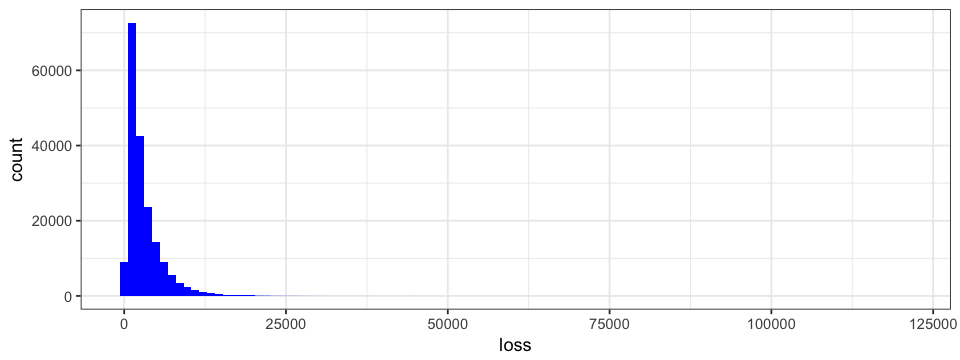

In [6]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(train, aes(x = loss)) + geom_histogram(bins = 100, fill = "blue") + theme_bw()

### Any thoughts?

## Prepare to modeling

In [7]:
y_train = train$loss
train[, c("id", "loss") := NULL]

XGBoost works only with numerical calues... any other should be converated to numerical.

### Categorical into numerical

In [8]:
df = train
features = colnames(df)
for (f in features) {
  if (class(df[[f]])=="character") {
    levels <- sort(unique(df[[f]]))
    df[[f]] <- as.integer(factor(df[[f]], levels=levels))
  }
}

## one hot encoding
can be slow...

In [9]:
oh.train = train

for (f in names(train)[names(train) %like% "^cat"]) {
    dmy <- dummyVars(sprintf(" ~ %s", f), data = train)
    newDum <- data.table(predict(dmy, newdata = train))
    
    oh.train = cbind(oh.train, newDum)
}

## train model

In [10]:
set.seed(2017)

dtrain = xgb.DMatrix(as.matrix(df), label=y_train)

xgb_params = list(
    objective='reg:linear', 
    eval_metric = "mae",
    max_depth = 10
)
model = xgb.train(xgb_params, dtrain, nrounds=30, maximize = F)

## predict model

In [11]:
y_pred = predict(model,dtrain)
mae(y_train, y_pred)

[1] 1000.238

## Any issues?

### Tips
- validation

###  k-fold Cross Validation

In [12]:
res = xgb.cv(
    xgb_params, 
    dtrain, 
    prediction =T,
    nrounds=30, 
    nfold=3,
    verbose=1
)

[1]	train-mae:2152.957113+2.281623	test-mae:2157.415365+5.944574 
[2]	train-mae:1636.751099+2.657723	test-mae:1654.780680+6.790026 
[3]	train-mae:1374.787923+4.061102	test-mae:1412.336996+5.278428 
[4]	train-mae:1246.118368+3.873905	test-mae:1303.169637+6.633263 
[5]	train-mae:1183.062175+4.489999	test-mae:1257.047689+5.867130 
[6]	train-mae:1149.142334+4.481677	test-mae:1239.291056+6.367507 
[7]	train-mae:1129.264445+3.455994	test-mae:1233.105225+5.175603 
[8]	train-mae:1112.900513+4.196062	test-mae:1230.322998+5.733712 
[9]	train-mae:1100.843710+4.859625	test-mae:1229.839071+4.838454 
[10]	train-mae:1091.784098+6.279170	test-mae:1229.102498+5.173990 
[11]	train-mae:1080.767537+6.693944	test-mae:1229.172852+4.650300 
[12]	train-mae:1071.430054+6.931214	test-mae:1227.766927+4.549364 
[13]	train-mae:1063.301717+5.744278	test-mae:1226.864828+4.254493 
[14]	train-mae:1052.167440+5.162500	test-mae:1225.626424+3.693644 
[15]	train-mae:1043.016113+5.596615	test-mae:1224.457194+3.725162 
[16]

## Any issues?

### Tips
- compare train-mae vs test-mae

Let's decrise `max_depth` from 10 to 5

In [13]:
xgb_params = list(
    objective='reg:linear', 
    eval_metric = "mae",
    max_depth = 5
)

res = xgb.cv(
    xgb_params, 
    dtrain, 
    prediction =T,
    nrounds=30, 
    nfold=3,
    verbose=1
)

[1]	train-mae:2158.215983+3.780003	test-mae:2158.639974+12.211875 
[2]	train-mae:1679.093547+3.132093	test-mae:1680.620117+10.530196 
[3]	train-mae:1455.197876+4.575172	test-mae:1459.535156+7.457458 
[4]	train-mae:1362.540975+5.386068	test-mae:1368.705444+6.960758 
[5]	train-mae:1322.655070+4.802611	test-mae:1330.361165+4.560403 
[6]	train-mae:1302.737996+5.336373	test-mae:1311.883748+3.271739 
[7]	train-mae:1295.298665+5.277894	test-mae:1306.068196+2.966862 
[8]	train-mae:1286.382324+3.841663	test-mae:1298.908895+4.681542 
[9]	train-mae:1279.228800+2.490701	test-mae:1292.964722+5.264319 
[10]	train-mae:1270.567952+4.286844	test-mae:1285.641398+4.489507 
[11]	train-mae:1263.781576+3.783077	test-mae:1280.389241+4.705804 
[12]	train-mae:1255.965251+4.375572	test-mae:1273.890788+3.223519 
[13]	train-mae:1248.881958+3.277119	test-mae:1267.195964+4.296500 
[14]	train-mae:1243.777913+3.918121	test-mae:1263.325521+4.117745 
[15]	train-mae:1237.758748+3.046710	test-mae:1258.207194+5.892727 
[1

### Play around with:
- eta
- subsample (0..1)
- colsample_bytree (0..1)

## Play around with target variable

In [14]:
#tips: check ggplot + scale_y_log10()

## Links
* [xgboost docs](http://xgboost.readthedocs.io/en/latest/R-package/xgboostPresentation.html)
* [tutorial #1](https://www.analyticsvidhya.com/blog/2016/01/xgboost-algorithm-easy-steps/) 
* [tutorial #2](https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/)